In [3]:
!pip install -q scikit-fuzzy tensorflow matplotlib numpy scikit-learn openpyxl pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
def load_dataset(file_path):
    df = pd.read_excel(file_path)
    print("\nDataset Head:")
    display(df.head())
    print("\nDataset Statistics:")
    display(df.describe())

    risk_mapping = {'Very Low': 0, 'Low': 1, 'Normal': 2, 'High': 3, 'Very High': 4}
    df['Risk_Num'] = df['Flood Risk Category'].map(risk_mapping)

    X = df[['Temp (°C)', 'Wind (Bft)', 'Atm (inHg)', 'Rate (inHg/3h)']].values
    y = df['Flood Intensity (mm/h)'].values
    return X, y, df

In [ ]:
temp = np.arange(0, 45.01, 0.1)
wind = np.arange(0, 15.01, 0.1)
atm = np.arange(27, 32.01, 0.01)
rate = np.arange(0, 1.1, 0.001)
rain = np.arange(0, 101, 0.1)

# Temperature
temp_vl = fuzz.trapmf(temp, [0, 0, 10, 15])
temp_l = fuzz.trimf(temp, [10, 15, 20])
temp_n = fuzz.trimf(temp, [15, 20, 30])
temp_h = fuzz.trimf(temp, [20, 30, 35])
temp_vh = fuzz.trapmf(temp, [30, 35, 45, 45])

# Wind
wind_vl = fuzz.trapmf(wind, [0, 0, 1, 3])
wind_l = fuzz.trimf(wind, [1, 3, 5])
wind_n = fuzz.trimf(wind, [3, 5, 8])
wind_h = fuzz.trimf(wind, [5, 8, 10])
wind_vh = fuzz.trapmf(wind, [8, 10, 15, 15])

# Pressure
atm_l = fuzz.trapmf(atm, [27, 27, 28.5, 29.5])
atm_n = fuzz.trimf(atm, [28.5, 29.5, 30.5])
atm_h = fuzz.trapmf(atm, [29.5, 30.5, 32, 32])

# Pressure change rate
rate_s = fuzz.trapmf(rate, [0, 0, 0.005, 0.01])
rate_sc = fuzz.trapmf(rate, [0.005, 0.01, 0.1, 0.2])
rate_rc = fuzz.trapmf(rate, [0.1, 0.2, 1.1, 1.1])

# Rainfall
rain_vl = fuzz.trimf(rain, [0, 0, 20])
rain_l = fuzz.trimf(rain, [0, 20, 40])
rain_n = fuzz.trimf(rain, [20, 40, 60])
rain_h = fuzz.trimf(rain, [40, 60, 80])
rain_vh = fuzz.trimf(rain, [60, 80, 100])

In [ ]:
def validate_inputs(t, w, a, r):
    return np.clip(t, 5, 40), np.clip(w, 0.5, 14), np.clip(a, 28, 31.5), np.clip(r, 0.001, 1.0)

def fuzzification(t, w, a, r):
    t, w, a, r = validate_inputs(t, w, a, r)
    return [
        [fuzz.interp_membership(temp, mf, t) for mf in [temp_vl, temp_l, temp_n, temp_h, temp_vh]],
        [fuzz.interp_membership(wind, mf, w) for mf in [wind_vl, wind_l, wind_n, wind_h, wind_vh]],
        [fuzz.interp_membership(atm, mf, a) for mf in [atm_l, atm_n, atm_h]],
        [fuzz.interp_membership(rate, mf, r) for mf in [rate_s, rate_sc, rate_rc]]
    ]

In [ ]:
def inference_engine(t_arr, w_arr, a_arr, r_arr):
    r1 = np.fmin(np.fmin(np.fmax(t_arr[0], t_arr[1]), np.fmax(w_arr[0], w_arr[1])), np.fmin(r_arr[0], a_arr[2]))
    r2 = np.fmin(np.fmax(np.fmin(t_arr[0], np.fmax(w_arr[2], w_arr[3])), np.fmin(r_arr[0], a_arr[1])), rain_l)
    r3 = np.fmin(np.fmax(t_arr[2], w_arr[2]), np.fmax(r_arr[1], a_arr[1]))
    r4 = np.fmin(np.fmax(t_arr[3], w_arr[3]), np.fmin(r_arr[1], a_arr[0]))
    r5 = np.fmin(np.fmin(t_arr[4], w_arr[4]), np.fmin(r_arr[2], a_arr[0]))
    agg = np.fmax(np.fmax(np.fmin(r1, rain_vl), r2), np.fmax(r3, np.fmax(r4, r5)))
    return np.fmax(agg, 0.01 * rain_vl)

def defuzzification(output):
    return fuzz.defuzz(rain, output, "centroid") if np.sum(output) else 50.0

In [ ]:
class FloodPredictionNN:
    def __init__(self, input_shape):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        self.model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        self.history = None

    def train(self, X_train, y_train, X_val, y_val, epochs=300, batch_size=32):
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
        self.history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                      epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=1)
        self.plot_history()

    def plot_history(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Val Loss')
        plt.legend(), plt.title('Loss Curve')

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['mae'], label='Train MAE')
        plt.plot(self.history.history['val_mae'], label='Val MAE')
        plt.legend(), plt.title('MAE Curve')
        plt.tight_layout()
        plt.show()

    def predict(self, X):
        return self.model.predict(X).flatten()

    def evaluate(self, X_test, y_test):
        preds = self.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        acc = 100 * (1 - (mae / np.mean(y_test)))
        print(f"MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | Accuracy: {acc:.2f}%")
        return {'mse': mse, 'mae': mae, 'r2': r2, 'accuracy': acc}


In [ ]:
class HybridFloodPredictor:
    def __init__(self, nn_model):
        self.nn_model = nn_model
        self.weights = {'fuzzy': 0.4, 'nn': 0.6}

    def _get_fuzzy_predictions(self, X):
        return np.array([defuzzification(inference_engine(*fuzzification(*x))) for x in X])

    def train_hybrid(self, X_val, y_val):
        fuzzy_pred = self._get_fuzzy_predictions(X_val)
        nn_pred = self.nn_model.predict(X_val)
        best_r2, best_weights = -np.inf, (0.5, 0.5)

        for w in np.linspace(0, 1, 11):
            hybrid = w * fuzzy_pred + (1 - w) * nn_pred
            score = r2_score(y_val, hybrid)
            if score > best_r2:
                best_r2, best_weights = score, (w, 1 - w)
        self.weights = {'fuzzy': best_weights[0], 'nn': best_weights[1]}
        print(f"Optimized Weights -> Fuzzy: {best_weights[0]:.2f}, NN: {best_weights[1]:.2f}")

    def predict(self, X):
        fuzzy_pred = self._get_fuzzy_predictions(X)
        nn_pred = self.nn_model.predict(X)
        return self.weights['fuzzy'] * fuzzy_pred + self.weights['nn'] * nn_pred

    def evaluate(self, X_test, y_test):
        pred = self.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        acc = 100 * (1 - (mae / np.mean(y_test)))
        print(f"Hybrid -> MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | Accuracy: {acc:.2f}%")
        return {'mse': mse, 'mae': mae, 'r2': r2, 'accuracy': acc}

In [8]:
X, y, _ = load_dataset('https://raw.githubusercontent.com/george-bobby/flood-prediction/main/notebooks/data.xlsx')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Dataset Head:


,Temp (°C),Wind (Bft),Atm (inHg),Rate (inHg/3h),Flood Intensity (mm/h),Flood Risk Category
0,25.49,7.85,28.86,0.63,78.1,High
1,29.13,12.49,28.25,0.85,84.7,Very High
2,13.08,1.49,31.25,0.02,13.9,Very Low
3,19.64,4.80,29.65,0.10,35.2,Low
4,34.30,9.34,28.46,0.72,81.0,Very High



Dataset Statistics:


,Temp (°C),Wind (Bft),Atm (inHg),Rate (inHg/3h),Flood Intensity (mm/h)
count,94.000000,94.000000,94.000000,94.000000,94.000000
mean,24.093830,6.289149,29.529255,0.299894,48.328723
std,7.021362,3.260182,0.959437,0.276858,24.470586
min,10.560000,1.020000,28.010000,0.000000,10.100000
25%,18.645000,3.752500,28.792500,0.070000,27.350000
50%,24.315000,5.890000,29.485000,0.195000,45.450000
75%,29.285000,8.817500,30.125000,0.497500,71.675000
max,39.690000,13.980000,31.400000,0.990000,86.300000



--- Neural Network Training ---
Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 707ms/step - loss: 3079.9094 - mae: 50.0854 - val_loss: 1853.4299 - val_mae: 36.8845
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 3148.8345 - mae: 50.9116 - val_loss: 1697.6466 - val_mae: 35.0098
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 2925.8618 - mae: 49.1306 - val_loss: 1559.0651 - val_mae: 33.2618
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 3116.5942 - mae: 50.8718 - val_loss: 1424.5465 - val_mae: 31.5084
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 2942.4797 - mae: 49.1581 - val_loss: 1295.6057 - val_mae: 29.8000
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 2784.5066 - mae: 47.7598 - val_loss: 1172.2919 - val_mae: 28.1342
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 2983.3398 - mae: 49.9062 - val_loss: 1052.9860 - val_mae: 26.4553
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 2727.1909 - mae: 47.5335 - val_loss: 935.5238 - val_mae: 24.7408
Epoch 9/300
2

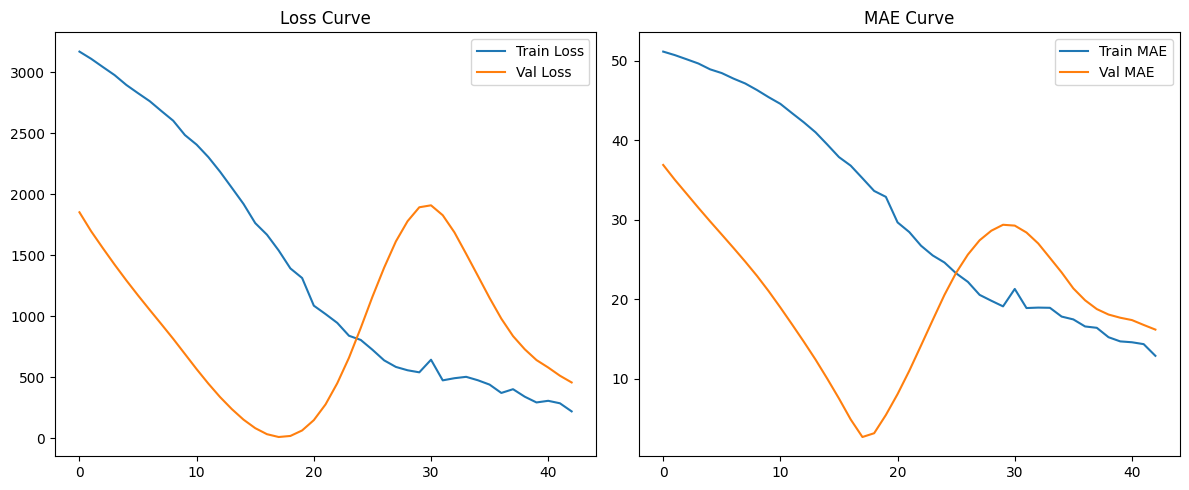

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
MSE: 50.4821 | MAE: 3.9711 | R²: 0.9293 | Accuracy: 91.13%


In [ ]:
print("\n--- Neural Network Training ---")
nn_model = FloodPredictionNN(input_shape=(X.shape[1],))
nn_model.train(X_train, y_train, X_val, y_val)
nn_metrics = nn_model.evaluate(X_test, y_test)

In [ ]:
print("\n--- Hybrid System Training ---")
hybrid = HybridFloodPredictor(nn_model)
hybrid.train_hybrid(X_val, y_val)
hybrid_metrics = hybrid.evaluate(X_test, y_test)


--- Hybrid System Training ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Optimized Weights -> Fuzzy: 0.10, NN: 0.90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Hybrid -> MSE: 57.4462 | MAE: 4.6836 | R²: 0.9196 | Accuracy: 89.54%


In [ ]:
print("\n--- Fuzzy System Evaluation ---")
fuzzy_preds = [defuzzification(inference_engine(*fuzzification(*x))) for x in X_test]
fuzzy_mse = mean_squared_error(y_test, fuzzy_preds)
fuzzy_mae = mean_absolute_error(y_test, fuzzy_preds)
fuzzy_r2 = r2_score(y_test, fuzzy_preds)
fuzzy_acc = 100 * (1 - fuzzy_mae / np.mean(y_test))
print(f"Fuzzy -> MSE: {fuzzy_mse:.4f} | MAE: {fuzzy_mae:.4f} | R²: {fuzzy_r2:.4f} | Accuracy: {fuzzy_acc:.2f}%")


--- Fuzzy System Evaluation ---
Fuzzy -> MSE: 455.5877 | MAE: 18.5236 | R²: 0.3622 | Accuracy: 58.62%


In [ ]:
print("\n--- Final Comparison ---")
print(f"{'System':<15}{'MSE':<10}{'MAE':<10}{'R²':<10}{'Accuracy':<10}")
print(f"{'Fuzzy':<15}{fuzzy_mse:<10.4f}{fuzzy_mae:<10.4f}{fuzzy_r2:<10.4f}{fuzzy_acc:<10.2f}%")
print(f"{'Neural Net':<15}{nn_metrics['mse']:<10.4f}{nn_metrics['mae']:<10.4f}{nn_metrics['r2']:<10.4f}{nn_metrics['accuracy']:<10.2f}%")
print(f"{'Hybrid':<15}{hybrid_metrics['mse']:<10.4f}{hybrid_metrics['mae']:<10.4f}{hybrid_metrics['r2']:<10.4f}{hybrid_metrics['accuracy']:<10.2f}%")


--- Final Comparison ---
System         MSE       MAE       R²        Accuracy  
Fuzzy          455.5877  18.5236   0.3622    58.62     %
Neural Net     50.4821   3.9711    0.9293    91.13     %
Hybrid         57.4462   4.6836    0.9196    89.54     %
